# Emotion classification project

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor
from time import time

import librosa as lr
import librosa.feature as lrf
import librosa.display as lrd

from multiprocessing import Pool
from FeatureExtractor import feature_extractor
import glob
import os
import traceback

import joblib

from pprint import pprint

np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
def create_data(path_list, n_masks=0, for_sklearn=True, n_mels=64, n_mfccs=20, only_mfccs=True):

    data = []
    target_class_list= []

    arg_list = [(x, n_masks, for_sklearn, n_mels, n_mfccs, only_mfccs) for x in path_list]

    with Pool(processes=8) as pool:
        processed_samples = pool.starmap(feature_extractor, arg_list)
        for s, t in processed_samples:
            data.extend(s)
            target_class_list.extend(t)

            
    return np.asarray(data), np.asarray(target_class_list)-1

## Scikit-learn model building

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from IncrementalSearch import time_taken
import scipy.stats as sst

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold, cross_val_score, train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

In [5]:
path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
targets = [int(path.split('-')[6]) for path in path_list]

X_train_paths, X_test_paths = train_test_split(path_list, stratify=targets, test_size=0.10, random_state=42)

In [6]:
X_train, y_train = create_data(X_train_paths)
X_test, y_test = create_data(X_test_paths)

joblib.dump(X_train, 'data/X_train'), joblib.dump(X_test, 'data/X_test')
joblib.dump(y_train, 'data/y_train'), joblib.dump(y_test, 'data/y_test')

In [6]:
X_train, y_train = joblib.load('data/X_train'), joblib.load('data/y_train')

target_labels = ['neutral',
                 'calm',
                 'happy',
                 'sad',
                 'angry',
                 'fearul',
                 'disgust',
                 'surprised']

for i in [X_train, y_train]:
    print(i.shape)
    
print(f'\nTrain set target label distribution:\n{pd.DataFrame(y_train).value_counts(normalize=True).sort_index()}\n')

(1296, 171)
(1296,)

Train set target label distribution:
0   0.06636
1   0.13349
2   0.13349
3   0.13349
4   0.13349
5   0.13349
6   0.13349
7   0.13272
dtype: float64



### Evaluating default performance

#### Does dataset augmentation make sense?

In [ ]:
def augmentation_cv(clf_list, names, mask_list, train_paths):
    
    mask_scores = {}
    
    for n in mask_list:
        folds = KFold()
        classifier_scores = {}
        print(f'Using {n} masks: \n')
        for name, classifier in zip(names, clf_list):
            fold_scores = []
            
            print(f'Classifier: {classifier[-1].__class__.__name__}\n')
            for i, (train, val) in enumerate(folds.split(train_paths)):

                t = time()
                print(f'Fold: {i+1}')

                X_train, y_train = create_data(np.array(train_paths)[train], n)
                X_val, y_val = create_data(np.array(train_paths)[val], 0)

                classifier.fit(X_train, y_train)

                y_pred = classifier.predict(X_val)            
                fold_scores.append(f1_score(y_val, y_pred, average='macro'))

                time_taken(t, True)
            print('============ END =============')    
            classifier_scores[name] = np.mean(fold_scores)

        mask_scores[n] = classifier_scores
    return mask_scores


In [ ]:
names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']

augmentation_pipes = [make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='liblinear')),
                      make_pipeline(RandomForestClassifier()),
                      make_pipeline(StandardScaler(), MLPClassifier(early_stopping=True)),
                      make_pipeline(XGBClassifier(tree_method='gpu_hist', objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, n_jobs=1))]

n_masks = [0, 1, 3, 5, 8, 10]

mask_scores = augmentation_cv(default_pipes, names, n_masks, X_train_paths)

joblib.dump(mask_scores, 'results/AugmentationResults')

In [ ]:
augmentation_svc = [make_pipeline(StandardScaler(), SVC(kernel='rbf')),
                    make_pipeline(StandardScaler(), SVC(kernel='linear')),
                    make_pipeline(StandardScaler(), SVC(kernel='poly'))]

n_masks = [0, 1, 3, 5, 8, 10]

mask_scores = augmentation_cv(svc_pipes, ['rbf', 'linear', 'poly'], n_masks, X_train_paths)

joblib.dump(mask_scores, 'results/SVCAugmentationResults')

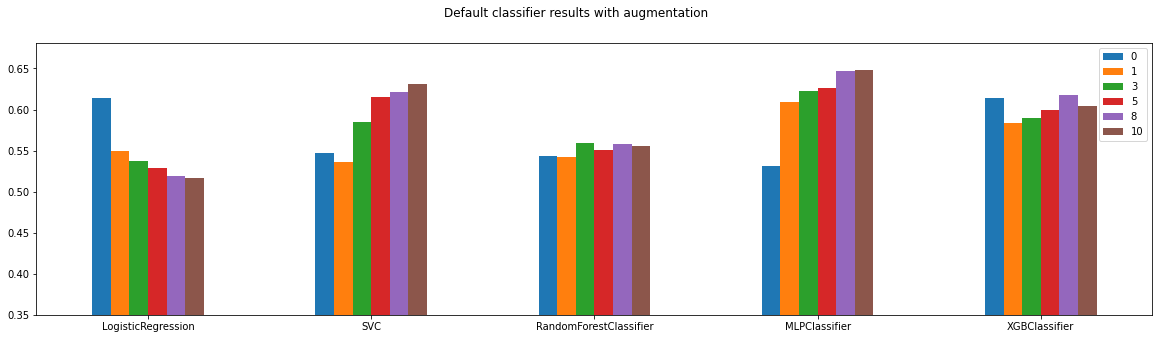

In [70]:
pd.DataFrame(joblib.load('results/AugmentationResults')).plot.bar(figsize=(20,5), ylim=(0.35), rot=0)
plt.suptitle('Default classifier results with augmentation')
plt.show()

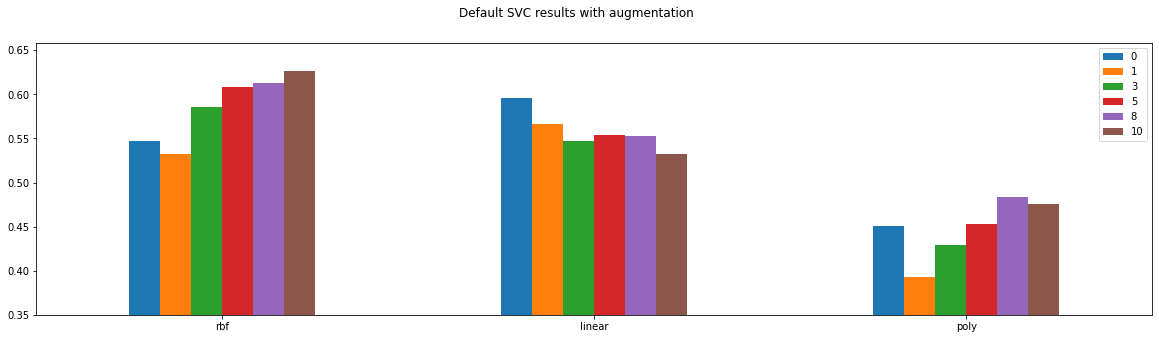

In [69]:
pd.DataFrame(joblib.load('results/SVCAugmentationResults')).plot.bar(figsize=(20,5), ylim=(0.35), rot=0)
plt.suptitle('Default SVC results with augmentation')
plt.show()

In [10]:
def aug_cv(clf, n_masks, train_paths, n_folds):
        
    fold_scores = []
    
    folds = StratifiedKFold(n_splits=n_folds)
    targets = [int(path.split('-')[6]) for path in train_paths]
    
    for i, (train, val) in enumerate(folds.split(train_paths, targets)):

        t = time()
        print(f'Fold: {i+1}')

        X_train, y_train = create_data(np.array(train_paths)[train], n_masks)
        X_val, y_val = create_data(np.array(train_paths)[val], 0)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)            
        fold_scores.append(f1_score(y_val, y_pred, average='macro'))

        time_taken(t, True)

    print('============ END =============\n')    
       
    return np.asarray(fold_scores)

In [72]:
%%time

default_names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']

default_pipes = [make_pipeline(StandardScaler(), LogisticRegression()),
                 make_pipeline(StandardScaler(), SVC()),
                 make_pipeline(RandomForestClassifier()),
                 make_pipeline(StandardScaler(), MLPClassifier()),
                 make_pipeline(XGBClassifier(tree_method='gpu_hist', objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, n_jobs=1))]

default_results = {}

for pipe, name in zip(default_pipes, default_names):
    print(f'Fitting estimator {pipe[-1]} with deafult parameters\n')
        
    t = time()
    result = cross_val_score(pipe, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, cv=5)
    time_taken(t, True)

    default_results[name] = result

joblib.dump(pd.DataFrame(default_results), 'results/DefaultResults')

Fitting estimator LogisticRegression() with deafult parameters



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Took time: 0h0min1s

Fitting estimator SVC() with deafult parameters



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Took time: 0h0min0s

Fitting estimator RandomForestClassifier() with deafult parameters



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Took time: 0h0min1s

Fitting estimator MLPClassifier() with deafult parameters



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished



Took time: 0h0min3s

Fitting estimator XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='mlogloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=None, ...) with deafult parameters



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.6s remaining:   43.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   28.8s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished



Took time: 0h0min29s

Wall time: 36.2 s


['results/DefaultResults']

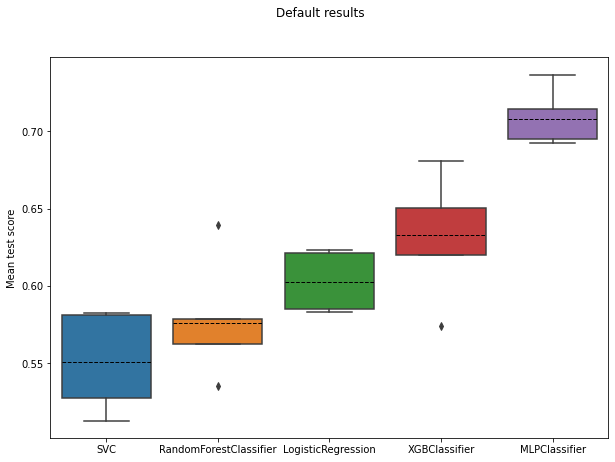


=====Cross-validation metrics======

With estimator: MLPClassifier

Mean F1-score: 0.708
Standard deviation: 0.016

============== END ===============


=====Cross-validation metrics======

With estimator: XGBClassifier

Mean F1-score: 0.633
Standard deviation: 0.036

============== END ===============


=====Cross-validation metrics======

With estimator: LogisticRegression

Mean F1-score: 0.603
Standard deviation: 0.017

============== END ===============


=====Cross-validation metrics======

With estimator: RandomForestClassifier

Mean F1-score: 0.576
Standard deviation: 0.035

============== END ===============


=====Cross-validation metrics======

With estimator: SVC

Mean F1-score: 0.551
Standard deviation: 0.028

============== END ===============



In [7]:
default_results = joblib.load('results/DefaultResults')

sorted_names = default_results.mean().sort_values().index

sorted_default_results = default_results[sorted_names]

plt.figure(figsize=(10,7))

sns.boxplot(data=sorted_default_results, medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})
plt.ylabel('Mean test score')
plt.xlabel(None)
plt.suptitle('Default results')
plt.show()

for name in np.flip(sorted_names):
    
    score = np.mean(default_results[name])
    std = np.std(default_results[name])
    
    print('\n=====Cross-validation metrics======\n')
    print(f'With estimator: {name}\n')
    print(f"Mean F1-score: {round(score, 3)}")
    print(f"Standard deviation: {round(std, 3)}\n")
    print('============== END ===============\n')
    

### Hyperparameter tuning

In [8]:
names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']
paths = [('searches/'+name+'Search', 'searches/'+name+'Results') for name in names]

searches, results = [], []

for p1, p2 in paths:
    searches.append(joblib.load(p1))
    results.append(joblib.load(p2))

In [9]:
columns_to_show = ['mean_test_score', 'std_test_score', 'rank_test_score', 'n_samples', 'params']

for i, name in enumerate(names):
    
    sorted_results = results[i][['mean_test_score', 'std_test_score', 'rank_test_score', 'n_samples', 'params']].sort_values(['mean_test_score'], ascending=False)
    
    with pd.option_context('display.max_colwidth', -1):
        print('\nTop 3 best performing parameters for model: '+name)
        display(sorted_results[:3])


Top 3 best performing parameters for model: LogisticRegression


,mean_test_score,std_test_score,rank_test_score,n_samples,params
334,0.61881,0.01619,1,1296,"{'clf__C': 5.182323505895209, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"
125,0.61827,0.01755,2,1296,"{'clf__C': 5.1096007572985185, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"
529,0.61757,0.01366,3,1296,"{'clf__C': 5.642107090110922, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}"



Top 3 best performing parameters for model: SVC


,mean_test_score,std_test_score,rank_test_score,n_samples,params
3913,0.73747,0.03028,1,1296,"{'clf__C': 4.073181932046468, 'clf__gamma': 1.0070740558594764, 'clf__kernel': 'rbf', 'decomp': PCA(n_components=0.99), 'scaler2': MinMaxScaler()}"
3059,0.73478,0.02121,2,1296,"{'clf__C': 3.7389329023788513, 'clf__gamma': 0.015317140891398554, 'clf__kernel': 'rbf', 'decomp': PCA(n_components=0.99), 'scaler2': StandardScaler()}"
1745,0.73044,0.02159,3,1296,"{'clf__C': 9.812414648924417, 'clf__gamma': 0.0054615296005484995, 'clf__kernel': 'rbf', 'decomp': PCA(), 'scaler2': 'passthrough'}"



Top 3 best performing parameters for model: RandomForestClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
5,0.61131,0.04421,1,1152,"{'clf__bootstrap': False, 'clf__criterion': 'entropy', 'clf__max_features': 12, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}"
44,0.61105,0.04430,2,1152,"{'clf__bootstrap': False, 'clf__criterion': 'entropy', 'clf__max_features': 10, 'clf__min_samples_split': 3, 'clf__n_estimators': 500}"
64,0.61063,0.04657,3,1152,"{'clf__bootstrap': False, 'clf__criterion': 'entropy', 'clf__max_features': 7, 'clf__min_samples_split': 3, 'clf__n_estimators': 500}"



Top 3 best performing parameters for model: MLPClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
66,0.74162,0.03179,1,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 1000, 'clf__learning_rate_init': 0.0005, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512, 128), 'clf__batch_size': 100, 'clf__activation': 'relu'}"
50,0.73852,0.02131,2,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 1000, 'clf__learning_rate_init': 0.0005, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512,), 'clf__batch_size': 100, 'clf__activation': 'relu'}"
70,0.73735,0.02938,3,1296,"{'scaler': StandardScaler(), 'clf__max_iter': 1000, 'clf__learning_rate_init': 0.0005, 'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (512, 64), 'clf__batch_size': 100, 'clf__activation': 'relu'}"



Top 3 best performing parameters for model: XGBClassifier


,mean_test_score,std_test_score,rank_test_score,n_samples,params
1897,0.66542,0.02965,1,1296,"{'clf__colsample_bytree': 0.9007123166538439, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.06126780910439317, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.7671253776764335, 'clf__tree_method': 'gpu_hist'}"
227,0.66377,0.03267,2,1296,"{'clf__colsample_bytree': 0.7886879685162956, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.011689319600720813, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.5318214214489826, 'clf__tree_method': 'gpu_hist'}"
241,0.66295,0.02491,3,1296,"{'clf__colsample_bytree': 0.5924101307502787, 'clf__eval_metric': 'mlogloss', 'clf__gamma': 0.002617805884371923, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__n_estimators': 500, 'clf__objective': 'multi:softmax', 'clf__subsample': 0.6181436488221598, 'clf__tree_method': 'gpu_hist'}"


### Cross-validation of models with best hyperparameters

In [76]:
%%time

optimized_results = {}

for i, name in enumerate(names):
    
    print(f'Fitting model {name} with best parameters\n')
    
    opt_estimator = searches[i][-1].best_estimator_
        
    t = time()
    result = cross_val_score(opt_estimator, X_train, y_train, scoring='f1_macro', n_jobs=-1, verbose=10, cv=5)
    time_taken(t, True)

    optimized_results[name] = result

joblib.dump(pd.DataFrame(optimized_results), 'results/OptimizedResults')

Fitting model LogisticRegression with best parameters



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished



Took time: 0h0min5s

Fitting model SVC with best parameters



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Took time: 0h0min0s

Fitting model RandomForestClassifier with best parameters



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.6s remaining:   39.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.7s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished



Took time: 0h0min26s

Fitting model MLPClassifier with best parameters



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.5s remaining:   38.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.0s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Took time: 0h0min26s

Fitting model XGBClassifier with best parameters



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   50.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   50.3s remaining:   33.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.5s finished



Took time: 0h0min50s

Wall time: 1min 50s


['results/OptimizedResults']

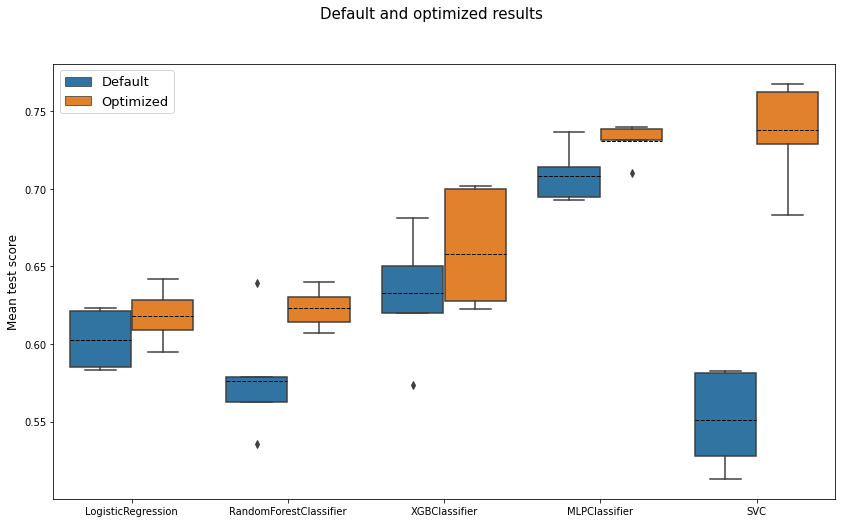


==== Cross-validation metrics ====

With estimator: SVC

Mean F1-score: 0.737
Standard deviation: 0.03

============== END ================


==== Cross-validation metrics ====

With estimator: MLPClassifier

Mean F1-score: 0.73
Standard deviation: 0.011

============== END ================


==== Cross-validation metrics ====

With estimator: XGBClassifier

Mean F1-score: 0.658
Standard deviation: 0.035

============== END ================


==== Cross-validation metrics ====

With estimator: RandomForestClassifier

Mean F1-score: 0.623
Standard deviation: 0.012

============== END ================


==== Cross-validation metrics ====

With estimator: LogisticRegression

Mean F1-score: 0.618
Standard deviation: 0.016

============== END ================



In [11]:
optimized_results, default_results = joblib.load('results/OptimizedResults'), joblib.load('results/DefaultResults')

sorted_optimized_results = optimized_results[optimized_results.mean().sort_values().index]

sorted_columns = sorted_optimized_results.columns
sorted_default_results = default_results[sorted_columns]

sorted_optimized_results = pd.melt(sorted_optimized_results)
sorted_default_results = pd.melt(sorted_default_results)

sorted_optimized_results['type'] = 'Optimized'
sorted_default_results['type'] = 'Default'

cdf = pd.concat((sorted_default_results, sorted_optimized_results))

plt.figure(figsize=(14,8))
plot = sns.boxplot(x='variable',  hue='type', y='value', data=cdf, medianprops={'linestyle':'None'}, showmeans=True, meanline=True, meanprops={'color':'black'})
plot.set_ylabel('Mean test score', fontsize=12)
plot.set_xlabel(None)
plt.suptitle('Default and optimized results', fontsize=15)
plt.legend(fontsize=13)
plt.show()

for name in np.flip(sorted_columns):
    score = round(np.mean(optimized_results[name]), 3)
    std = round(np.std(optimized_results[name]), 3)
    
    print('\n==== Cross-validation metrics ====\n')
    print(f'With estimator: {name}\n')
    print(f"Mean F1-score: {score}")
    print(f"Standard deviation: {std}\n")
    print('============== END ================\n')

In [12]:
%%time

best_classifiers = [searches[i][-1].best_estimator_ for i in range(len(optimized_results.columns))]

for clf in best_classifiers:
    
    print(f'Fitting estimator {clf[-1].__class__.__name__}\n')
    clf.fit(X_train, y_train)
    
    joblib.dump(clf, 'models/'+clf[-1].__class__.__name__)

Fitting estimator LogisticRegression

Fitting estimator SVC

Fitting estimator RandomForestClassifier

Fitting estimator MLPClassifier

Fitting estimator XGBClassifier

Wall time: 59.7 s


## Keras convolution neural network

In [14]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.regularizers import l2

import keras_tuner as kt
from keras_tuner import HyperParameters

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
%%time

path_list = glob.glob('speech-emotion-recognition-ravdess-data/Actor_*/*')
path_targets = [int(path.split('-')[6]) for path in path_list]

temp, X_test_paths = train_test_split(path_list, stratify=path_targets, test_size=0.10, random_state=42)
X_train_paths, X_val_paths = train_test_split(temp, stratify=[int(path.split('-')[6]) for path in temp], test_size=0.15, random_state=42)

X_train_keras, y_train_keras = create_data(X_train_paths, n_masks=5, for_sklearn=False, n_mels=128, n_mfccs=20)
X_val_keras, y_val_keras = create_data(X_val_paths, for_sklearn=False, n_mels=128, n_mfccs=20)
X_test_keras, y_test = create_data(X_test_paths, for_sklearn=False, n_mels=128, n_mfccs=20)

joblib.dump(X_train_keras, 'data/X_train_keras'), joblib.dump(X_val_keras, 'data/X_val_keras')
joblib.dump(y_train_keras, 'data/y_train_keras'), joblib.dump(y_val_keras, 'data/y_val_keras')
joblib.dump(X_test_keras, 'data/X_test_keras')

Wall time: 1min 51s


['data/X_test_keras']

In [25]:
X_train_keras, X_val_keras = joblib.load('data/X_train_keras'), joblib.load('data/X_val_keras')
y_train_keras, y_val_keras = joblib.load('data/y_train_keras'), joblib.load('data/y_val_keras')

y_train_cat = keras.utils.to_categorical(y_train_keras, 8)
y_val_cat = keras.utils.to_categorical(y_val_keras, 8)

target_labels = ['neutral',
                 'calm',
                 'happy',
                 'sad',
                 'angry',
                 'fearul',
                 'disgust',
                 'surprised']

print(X_train_keras.shape)
print(X_val_keras.shape)
print(y_train_cat.shape)
print(y_val_cat.shape)

(6606, 20, 69, 1)
(195, 20, 69, 1)
(6606, 8)
(195, 8)


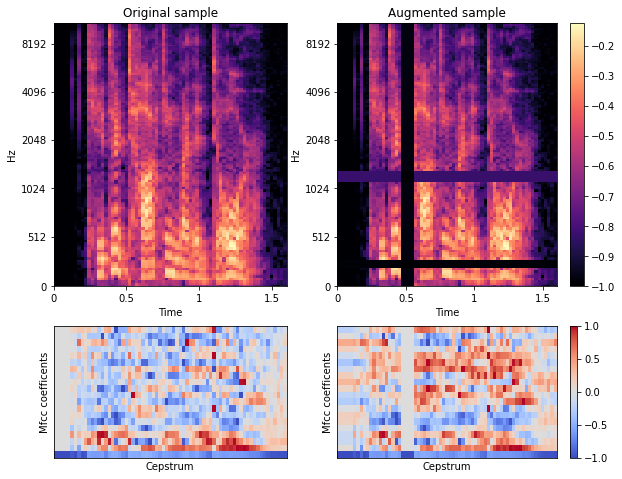

In [15]:
test_path=['speech-emotion-recognition-ravdess-data/Actor_07/03-01-07-01-01-01-07.wav']

test, _ = create_data(test_path, n_masks=1, for_sklearn=False, n_mels=128, n_mfccs=20, only_mfccs=False)

fig, axs = plt.subplots(2,2, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 0.5], 'width_ratios': [0.85, 1]}, sharey=False)

mel = lrd.specshow(test[0][:128,:,0], y_axis='mel', x_axis='time', ax=axs[0,0])
axs[0,0].set_title('Original sample')

mfcc = lrd.specshow(test[0][128:,:,0], ax=axs[1,0])
axs[1,0].set_xlabel('Cepstrum')
axs[1,0].set_ylabel('Mfcc coefficents')

mel = lrd.specshow(test[1][:128,:,0], y_axis='mel', x_axis='time', ax=axs[0,1])
fig.colorbar(mel, ax=axs[0,1])
axs[0,1].set_title('Augmented sample')

mfcc = lrd.specshow(test[1][128:,:,0], ax=axs[1,1])
fig.colorbar(mfcc, ax=axs[1,1])
axs[1,1].set_xlabel('Cepstrum')
axs[1,1].set_ylabel('Mfcc coefficents')

plt.show()

### Network training

In [60]:
def create_default_model():
    
    model = Sequential()
    
    model.add(Input(shape=X_train_keras[0].shape))
    
    model.add(Conv2D(32, 3, padding='same'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, 3, padding='same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(3,3)))
    
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, 3, padding='same'))
    model.add(Activation('relu'))
      
    model.add(Conv2D(64, 3, padding='same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(3,3)))
    
    model.add(Flatten())
    
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [61]:
default_keras = create_default_model()

default_keras.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 20, 69, 32)        320       
                                                                 
 activation (Activation)     (None, 20, 69, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 20, 69, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 20, 69, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 6, 23, 32)         0         
                                                      

In [ ]:
default_keras = create_default_model()

default_history = default_keras.fit(X_train_keras, y_train_cat, batch_size=16,
                                    epochs=100, validation_data=(X_val_keras, y_val_cat),
                                    shuffle=True, callbacks=[keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=7)])

joblib.dump(default_history.history, 'results/DefaultConv2DHistory')

In [17]:
def plot_metrics(history):
    
    fitted_epochs = len(history['val_loss'])
    
    print(f"Best lowest validation loss on epoch: {np.argmin(history['val_loss']) + 1}\n")

    fig = plt.figure(figsize=(12,6))

    ax = fig.add_subplot(121)
    ax.plot(range(fitted_epochs), history['loss'], 'r', label='Training loss')
    ax.plot(range(fitted_epochs), history['val_loss'], 'b', label='Validation loss')
    ax.legend()
    ax.set_ylim(0)
    ax.set_xlabel('Epochs'), ax.set_ylabel('Validation loss')
    ax.set_title('Loss over epochs')

    ax = fig.add_subplot(122)
    ax.plot(range(fitted_epochs), history['accuracy'], 'r', label='Training accuracy')
    ax.plot(range(fitted_epochs), history['val_accuracy'], 'b', label='Validation accuracy')
    ax.legend()
    ax.set_ylim(0, 1.0)
    ax.set_xlabel('Epochs'), ax.set_ylabel('Validation accuracy')
    ax.set_title('Accuracy over epochs')

    plt.show()

Best lowest validation loss on epoch: 43



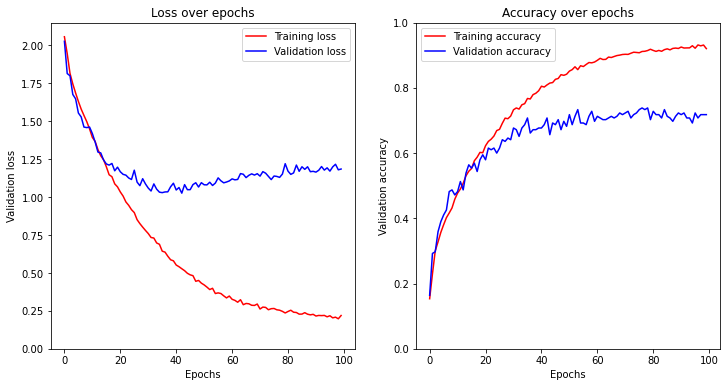

In [18]:
default_history = joblib.load('results/DefaultConv2DHistory')

plot_metrics(default_history)

In [ ]:
def keras_cv(create_model, X, y, cv, final_epochs, callbacks):
    
    from keras import backend as K
    
    scores = []
    for temp, test in cv.split(X, y):
        
        model = create_model()
        
        ss = StandardScaler()
        
        X_test, y_test = X[test], y[test]
        
        X_, y_ = X[temp], y[temp]
        
        train, val = next(StratifiedShuffleSplit(n_splits=1, test_size=0.2).split(X_, y_))
                
        X_train, y_train = X_[train], y_[train]
        X_val, y_val = X_[val], y_[val]
                
        X_train, X_val = ss.fit_transform(X_train), ss.transform(X_val)
                
        X_train = X_train.reshape(X_train.shape[0], 212, 95, 1).astype(np.float32)
        X_val = X_val.reshape(X_val.shape[0], 212, 95, 1).astype(np.float32)
        
        y_train_cat = keras.utils.to_categorical(y_train, 8)
        y_val_cat = keras.utils.to_categorical(y_val, 8)    
        
        model.fit(X_train, y_train_cat, epochs=100, validation_data=(X_val, y_val_cat),
                    shuffle=True, callbacks=callbacks)

        
        X_scaled, X_test_scaled = ss.fit_transform(X_), ss.transform(X_test)
        X_scaled = X_scaled.reshape(X_scaled.shape[0], 212, 95, 1).astype(np.float32)
        X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 212, 95, 1).astype(np.float32)
        
        y_cat = keras.utils.to_categorical(y_, 8)
        
        model.fit(X_scaled, y_cat, epochs=1)
        
        y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)
        
        scores.append(f1_score(y_test, y_pred, average='macro'))
        
        K.clear_session()
        del model
        
    return scores


In [ ]:
default_scores = keras_cv(create_default_model, X, y, StratifiedKFold(n_splits=4), 1, [keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)])
joblib.dump(default_scores, 'results/DefaultConv2DResults')

In [ ]:
default_scores = joblib.load('results/DefaultConv2DResults')

mean_score = np.mean(default_scores)
std = np.std(default_scores)

print('\n==== Cross-validation metrics ====\n')
print(f'With default Keras Conv2D Classifier:\n')
print(f"Mean F1-score: {mean_score}")
print(f"Standard deviation: {std}\n")
print('============== END ===============\n')

### Optimizing Keras classifier

In [21]:
best_hp = joblib.load('searches/KerasHP')

best_hp.values

{'filters1': 64,
 'filters2': 64,
 'filters3': 128,
 'filters4': 64,
 'dropout1': 0.4,
 'units1': 512,
 'dropout2': 0.2,
 'dropout3': 0,
 'dropout4': 0.75,
 'dropout5': 0.2}

In [54]:
def build_optimized_model(hp):
    
    model = Sequential()
    
    model.add(Input(shape=X_train_keras[1].shape))

    model.add(Conv2D(
        hp.Int('filters1', min_value=16, max_value=64, step=16, default=32), 
        kernel_size=3,
        activation='relu',
        padding='same'))

    model.add(Dropout(hp.Choice('dropout1', [0.0, 0.2, 0.3, 0.4])))

    model.add(Conv2D(
        hp.Int('filters2', min_value=16, max_value=64, step=16, default=32),
        kernel_size=3,
        activation='relu',
        padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.75, sampling='linear')))

    model.add(Conv2D(
        hp.Int('filters3', min_value=32, max_value=128, step=16, default=64), 
        kernel_size=3,
        activation='relu',
        padding='same'))
    
    model.add(Dropout(hp.Choice('dropout3', [0.0, 0.2, 0.3, 0.4])))

    model.add(Conv2D(
        hp.Int('filters4', min_value=32, max_value=128, step=16, default=64), 
        kernel_size=3,
        activation='relu',
        padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Flatten())

    model.add(Dropout(hp.Float('dropout4', min_value=0.2, max_value=0.75, sampling='linear')))
              
    model.add(Dense(
        units = hp.Int('units1', min_value=64, max_value=512, step=64),
        activation = 'relu'))

    model.add(Dropout(hp.Float('dropout5', min_value=0.2, max_value=0.5, sampling='linear')))

    model.add(Dense(8, activation='softmax'))
    
    model.compile(keras.optimizers.Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        
    return model

In [55]:
optimized_keras = build_optimized_model(best_hp)

optimized_keras.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 20, 69, 64)        640       
                                                                 
 dropout_20 (Dropout)        (None, 20, 69, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 69, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 23, 64)        0         
 2D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 6, 23, 64)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 23, 128)        73856     
                                                      

In [ ]:
optimized_history = optimized_keras.fit(X_train_keras, y_train_cat, batch_size=16,
                                    epochs=200, validation_data=(X_val_keras, y_val_cat),
                                    shuffle=True, callbacks=[keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
                                                             keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=7)])

X_keras = np.concatenate((X_train_keras, X_val_keras))
y_cat = np.concatenate((y_train_cat, y_val_cat))

optimized_keras.fit(X_keras, y_cat, epochs=1)

optimized_keras.save('models/Conv2DClassifier')
joblib.dump(optimized_history.history, 'results/OptimizedConv2DHistory')

Best lowest validation loss on epoch: 93



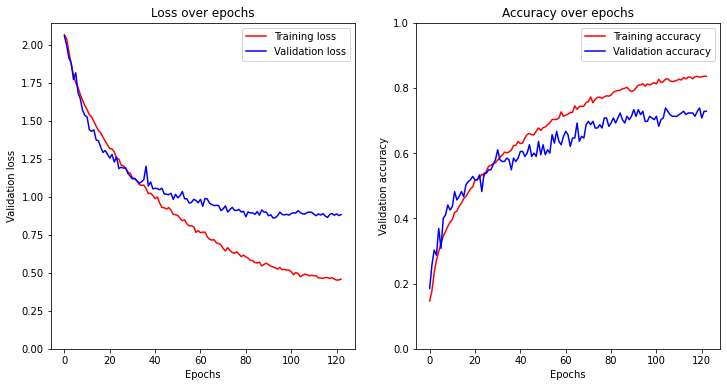

In [57]:
optimized_history = joblib.load('results/optimizedConv2DHistory')
plot_metrics(optimized_history)

In [ ]:
callbacks=[keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
           keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1)]

better_scores = keras_cv(create_optimized_model, X, y, StratifiedKFold(n_splits=4), 1, callbacks=callbacks)

joblib.dump(better_scores, 'results/OptimizedConv2DResults')

In [14]:
better_scores = joblib.load('results/OptimizedConv2DResults')

mean_score = np.mean(better_scores)
std = np.std(better_scores)

print('\n==== Cross-validation metrics ====\n')
print(f'With Optimized Keras Conv2D Classifier:\n')
print(f"Mean F1-score: {mean_score}")
print(f"Standard deviation: {std}\n")
print('============== END ===============\n')


==== Cross-validation metrics ====

With Optimized Keras Conv2D Classifier:

Mean F1-score: 0.8788626580612111
Standard deviation: 0.011527596159019793

============== END ===============



## Out-of-sample evaluation for all classifiers

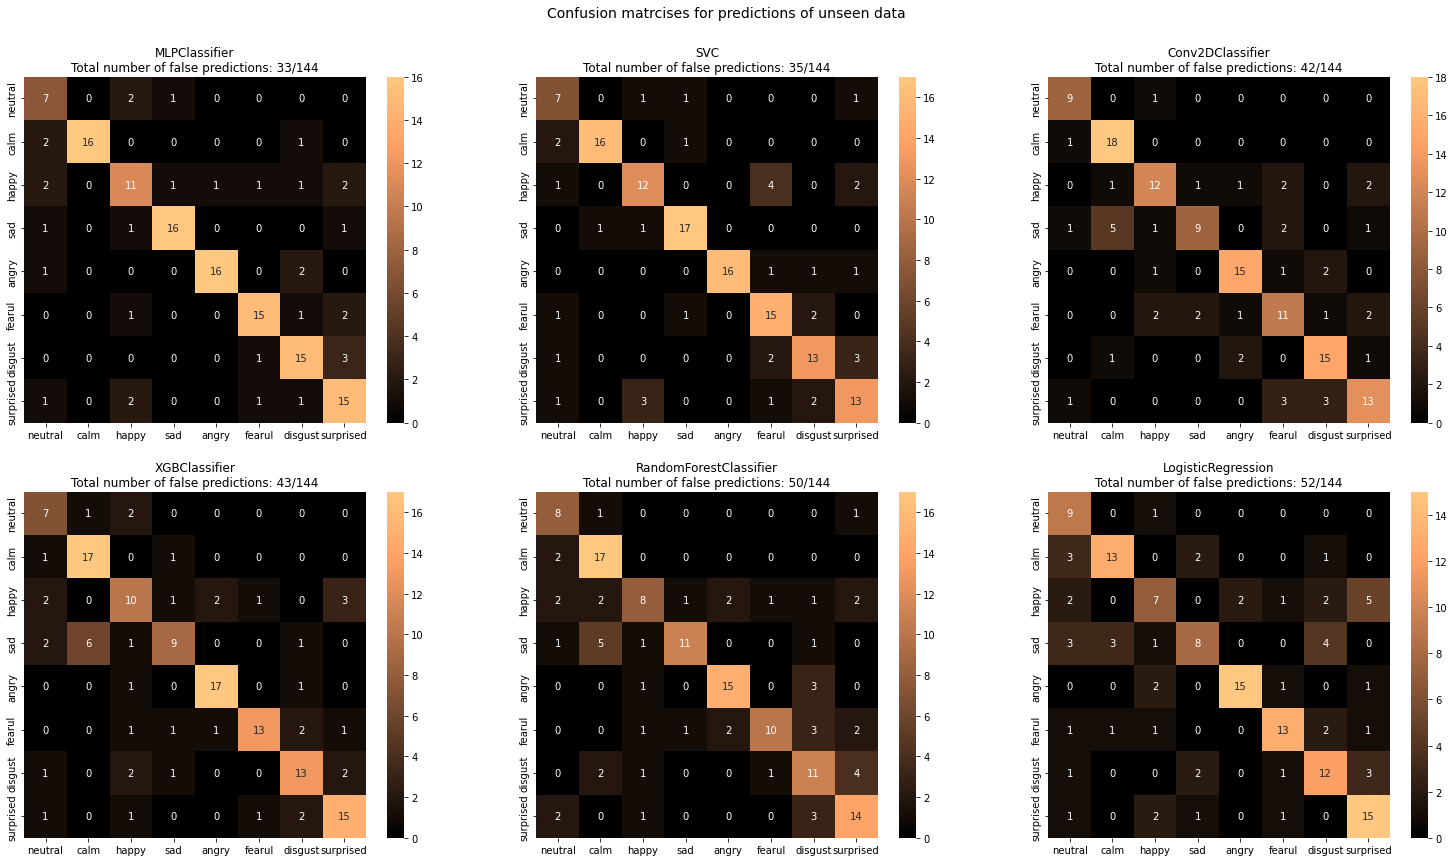


========= Evaluation ==========

With estimator: MLPClassifier

F1-score: 0.765
Accuracy: 0.771

============ END ==============


========= Evaluation ==========

With estimator: SVC

F1-score: 0.752
Accuracy: 0.757

============ END ==============


========= Evaluation ==========

With estimator: Conv2DClassifier

F1-score: 0.709
Accuracy: 0.708

============ END ==============


========= Evaluation ==========

With estimator: XGBClassifier

F1-score: 0.691
Accuracy: 0.701

============ END ==============


========= Evaluation ==========

With estimator: RandomForestClassifier

F1-score: 0.649
Accuracy: 0.653

============ END ==============


========= Evaluation ==========

With estimator: LogisticRegression

F1-score: 0.634
Accuracy: 0.639

============ END ==============



In [16]:
X_test, X_test_keras, y_test = joblib.load('data/X_test'), joblib.load('data/X_test_keras'), joblib.load('data/y_test')

names = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier']

clfs = [joblib.load('models/'+name) for name in names]

temp = [(name, clf.predict(X_test), f1_score(y_test, clf.predict(X_test), average='macro')) for clf, name in zip(clfs, names)]

clf_keras = keras.models.load_model('models/Conv2DClassifier')
y_pred_keras = np.argmax(clf_keras.predict(X_test_keras), axis=-1)
f1_keras = f1_score(y_test, y_pred_keras, average='macro')

temp.append(('Conv2DClassifier', y_pred_keras, f1_keras))

sorted_clfs = sorted(temp, key= lambda x: x[2], reverse=True)

fig, axs = plt.subplots(2, 3, figsize=(26,14))

axlist = axs.flatten()

for ax, (name, y_pred, f1) in zip(axlist, sorted_clfs):
    
    cm = confusion_matrix(y_test, y_pred)
    fp = cm.sum(axis=0) - np.diag(cm)  
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='copper', xticklabels=target_labels, yticklabels=target_labels)
    ax.set_title(f'{name}\nTotal number of false predictions: {sum(fp)}/{len(y_test)}')
    
plt.suptitle('Confusion matrcises for predictions of unseen data', fontsize=14, y=0.95)
plt.show()

for name, y_pred, f1 in sorted_clfs:

    print('\n========= Evaluation ==========\n')
    print(f'With estimator: {name}\n')
    print(f"F1-score: {round(f1, 3)}")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}\n")
    print('============ END ==============\n')